In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

Data type: uint8
Data shape: (512, 512, 7)


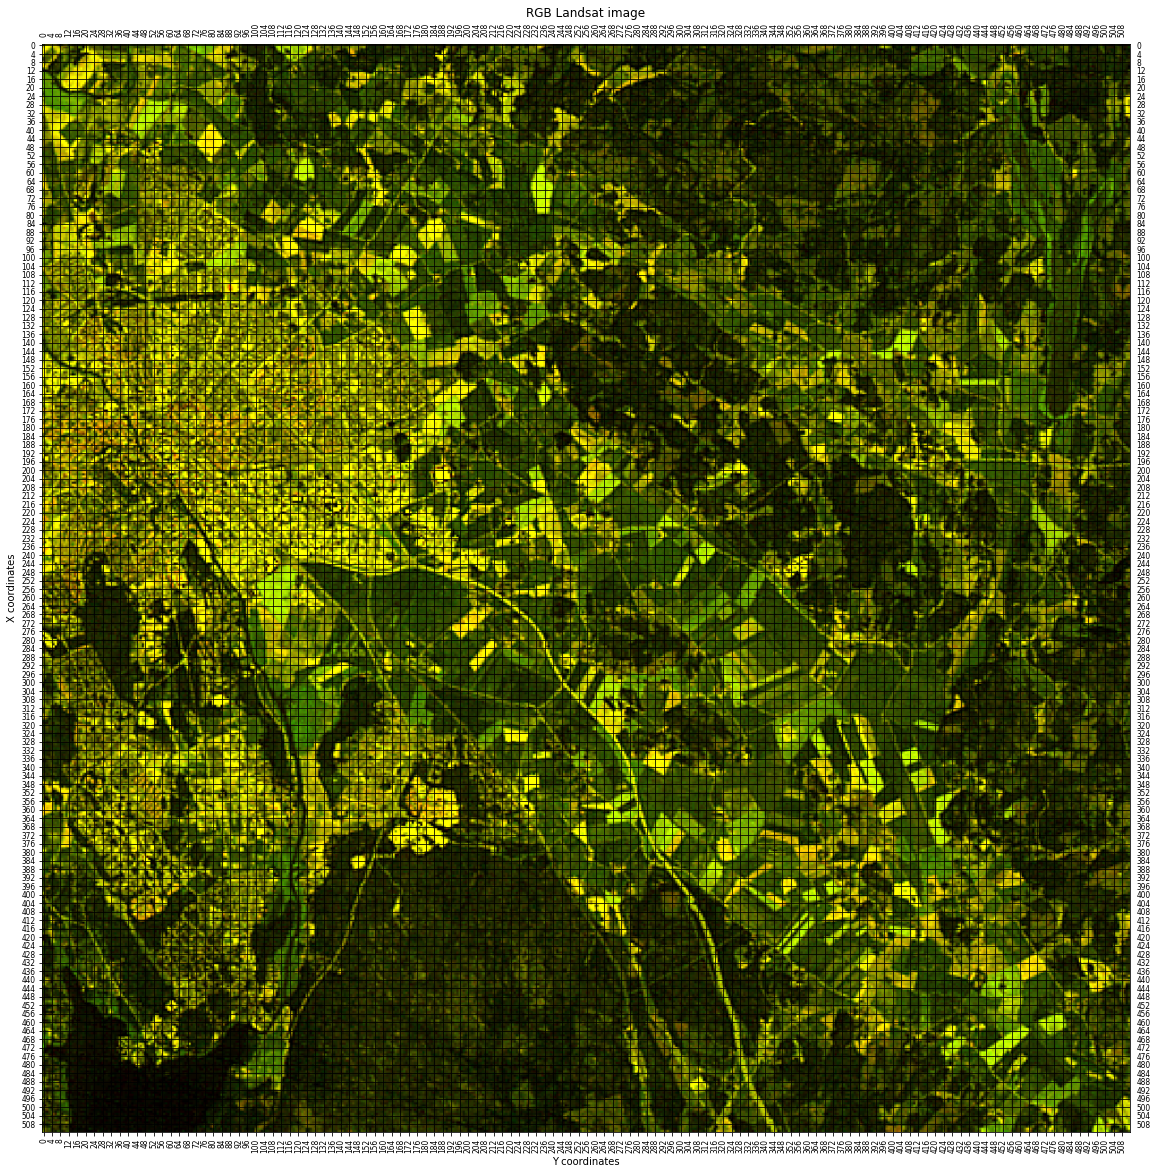

In [2]:
data = loadmat('./data/landsat_data.mat')
im = np.array(data['landsat_data'])
print(f'Data type: {im.dtype}')
print(f'Data shape: {im.shape}')

# Computation of NDVI:
numerator = cv.subtract(src1=im[:,:,3], src2=im[:,:,2])
denominator = cv.addWeighted(src1=im[:,:,3], alpha=0.5, src2=im[:,:,2], beta=0.5, gamma=0)
ndvi = cv.divide(src1=numerator, src2=denominator)
ndvi = np.expand_dims(ndvi, axis=2)
im = np.dstack([im, ndvi])

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))

ax0.imshow(im[:,:, (2,1,7)])
ax0.set_title('RGB Landsat image')
ax0.set_xticks(np.linspace(start=0, stop=im.shape[0], num=128, endpoint=False).astype(int))
ax0.set_yticks(np.linspace(start=0, stop=im.shape[1], num=128, endpoint=False).astype(int))
ax0.tick_params(axis="x", labelsize=8, rotation=90, labeltop=True)
ax0.tick_params(axis="y", labelsize=8, rotation=0, labelright=True)
ax0.set_xlabel('Y coordinates')
ax0.set_ylabel('X coordinates')
ax0.grid(color='black', linestyle='-', linewidth=0.8)

In [3]:
# Mapping: 1 water, 2 urban area, 3 agriculture area, 4 forest
data = np.zeros(shape=(im.shape[0], im.shape[1], 2), dtype=np.uint8)

data[491:501, 30:40] = [1,1]
data[112:128, 481:486] = [1,2]
data[143:158, 476:481] = [1,3]

data[153:168, 76:87] = [2,4]
data[230:240, 128:138] = [2,5]
data[184:189, 10:25] = [2,6]
data[158:173, 158:173] = [2,7]

data[353:368, 291:307] = [3,8]
data[261:266, 322:337] = [3,9]
data[122:126, 325:345] = [3,10]
data[58:65, 380:391] = [3,11]

data[460:470, 150:180] = [4,12]
data[163:173, 276:286] = [4,13]
data[476:506, 373:378] = [4,14]
data[220:235, 384:400] = [4,15]

x_coord, y_coord = data[:,:,0].nonzero()
d = {'PolygonID': data[x_coord, y_coord, 1],
     'x_coord': x_coord,
     'y_coord': y_coord,
     'B1': im[x_coord, y_coord, 0],
     'B2': im[x_coord, y_coord, 1],
     'B3': im[x_coord, y_coord, 2],
     'B4': im[x_coord, y_coord, 3],
     'B5': im[x_coord, y_coord, 4],
     'B6': im[x_coord, y_coord, 5],
     'B7': im[x_coord, y_coord, 6],
     'NDVI': im[x_coord, y_coord, 7],
     'Class': data[x_coord, y_coord, 0]
     }
df_data = pd.DataFrame(data=d, dtype=np.uint8)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   PolygonID  2082 non-null   uint8
 1   x_coord    2082 non-null   uint8
 2   y_coord    2082 non-null   uint8
 3   B1         2082 non-null   uint8
 4   B2         2082 non-null   uint8
 5   B3         2082 non-null   uint8
 6   B4         2082 non-null   uint8
 7   B5         2082 non-null   uint8
 8   B6         2082 non-null   uint8
 9   B7         2082 non-null   uint8
 10  NDVI       2082 non-null   uint8
 11  Class      2082 non-null   uint8
dtypes: uint8(12)
memory usage: 24.5 KB


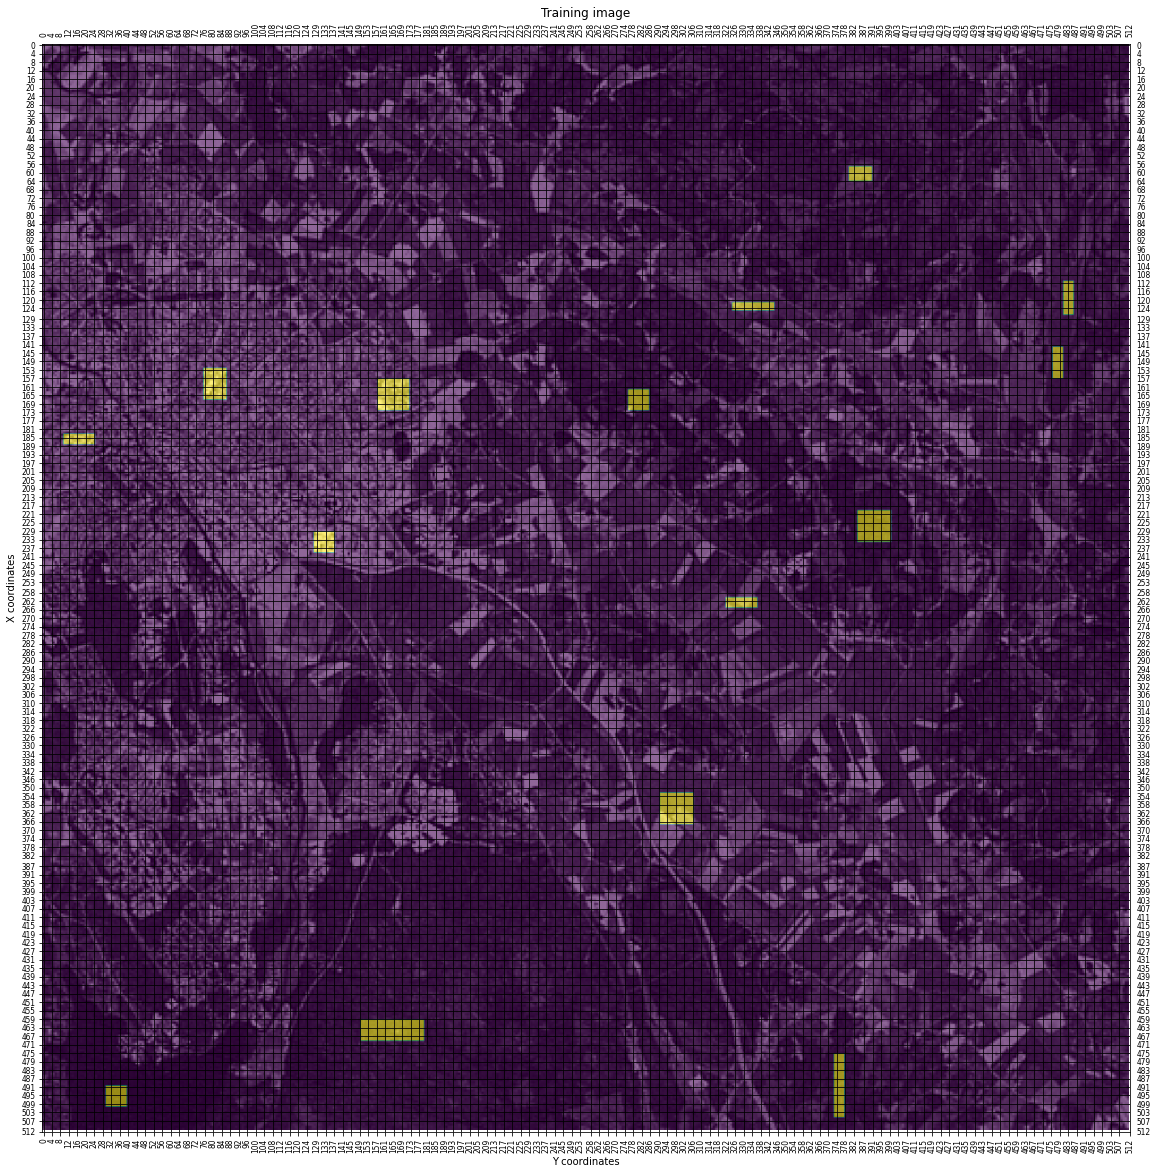

In [4]:
data_mask = np.zeros(shape=data.shape[:-1])
data_mask[np.nonzero(data[:,:,0])] = 255

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax0.imshow(cv.cvtColor(src=im[:,:,(2,1,7)], code=cv.COLOR_RGB2GRAY), cmap=cm.gray)
ax0.imshow(data_mask, alpha=0.6)
ax0.set_title('Training image')
ax0.set_xticks(np.linspace(start=0, stop=im.shape[0], num=128, endpoint=False).astype(int))
ax0.set_yticks(np.linspace(start=0, stop=im.shape[1], num=128, endpoint=False).astype(int))
ax0.tick_params(axis="x", labelsize=8, rotation=90, labeltop=True)
ax0.tick_params(axis="y", labelsize=8, rotation=0, labelright=True)
ax0.set_xlabel('Y coordinates')
ax0.set_ylabel('X coordinates')
ax0.grid(color='black', linestyle='-', linewidth=0.8)

In [5]:
data_size = df_data.shape[0]
trainIndex = np.random.choice(data_size, size=int(0.75*data_size), replace=False)
train_dataset = df_data.iloc[trainIndex]
test_dataset = df_data.iloc[~df_data.index.isin(trainIndex)]

train_x, train_y = train_dataset.drop(columns=['Class'], inplace=False), train_dataset['Class']
test_x, test_y = test_dataset.drop(columns=['Class'], inplace=False), test_dataset['Class']

In [6]:
def box_plot(channel):
    #Change to only look at training data
    feature = train_dataset[f'B{channel}']
    c1 = feature[train_dataset['Class'] == 1]
    c2 = feature[train_dataset['Class'] == 2]
    c3 = feature[train_dataset['Class'] == 3]
    c4 = feature[train_dataset['Class'] == 4]

    my_dict = {'Water': c1, 'Urban': c2, 'Agriculture': c3, 'Forest': c4}

    fig, ax = plt.subplots()
    ax.set_title(f'Boxplot Channel = {channel}')
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())

<class 'pandas.core.series.Series'>


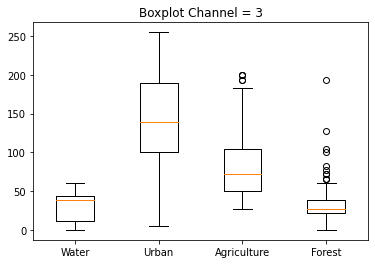

In [7]:
box_plot(3)

In [8]:
# predictions, (train_x_bg, train_y) = train_multiplefeature(im, data, 'RF')
# fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# ax0.imshow(im[:,:,(2,1,0)])
# ax0.set_title('RGB Landsat image')
# ax0.axis('off')
# ax1.imshow(predictions)
# ax1.set_title('Predictions')
# ax1.axis('off')

NameError: name 'train_multiplefeature' is not defined

Out-of-bag accuracy estimate: 1.0


/usr/local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


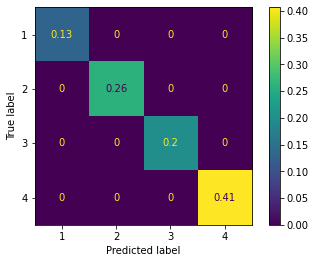

In [9]:
rf_classifier = RandomForestClassifier(n_estimators=20, max_features='auto', max_samples=0.75, max_depth=20, oob_score=True)
rf_classifier.fit(train_x, train_y)
print(f'Out-of-bag accuracy estimate: {rf_classifier.oob_score_}')
predictions = rf_classifier.predict(test_x)
ConfusionMatrixDisplay.from_predictions(y_true = test_y, y_pred=predictions, normalize='all')